In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import torch.nn as nn
from src.model.ResBlock import ResBlockConv, ResBlockConvTranspose
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


class Net(nn.Module):

    def __init__(self, args):
        super(Net, self).__init__()

        # parameters
        self.z_channels = args.z_channels
        self.z_h = args.z_h
        self.z_w = args.z_w
        self.z_dim = self.z_channels * self.z_h * self.z_w
        self.img_dim = args.img_dim
        self.batch_size = args.batch_size
        self.hidden_dim = args.hidden_dim
        self.channels = args.channels
        self.device = args.device
        
        # posterior
        self.fc1 = nn.Linear(self.z_dim, self.z_dim)
        self.fc2 = nn.Linear(self.z_dim, self.z_dim)
 
        # other
        self.relu = nn.ELU()
        self.kld_weight = 1.0 / 99.0
        
        # reconstruction loss function
        if args.recon_loss == "BCE":
            self.recon_loss = nn.BCELoss(reduction='none')
        elif args.recon_loss == "MSE":
            self.recon_loss = nn.MSELoss(reduction='none')
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(self.channels, self.hidden_dim, 4, 2, 1, bias=False), # 8x8 --> 16x16
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 16x16 --> 32x32
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 32x32 --> 64x64
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 64x64 --> 128x128
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 128x128 --> 256x256
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 256x256 --> 512x512
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            ResBlockConv(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            ResBlockConv(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            nn.Conv2d(self.hidden_dim, self.z_channels, 3, 1, 1, bias=True) # 512x512 --> 512x512
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.z_channels, self.hidden_dim, 4, 2, 1, bias=False), # 8x8 --> 16x16
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 16x16 --> 32x32
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 32x32 --> 64x64
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 64x64 --> 128x128
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 128x128 --> 256x256
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 256x256 --> 512x512
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            ResBlockConvTranspose(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            ResBlockConvTranspose(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            nn.ConvTranspose2d(self.hidden_dim, self.channels, 3, 1, 1, bias=True) # 512x512 --> 512x512
        )

    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def reparameterize(self, mu, logvar, just_mean=False):
        if just_mean:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(logvar)
            return mu + eps * std

    def update_device(self, device):
        self.device = update_device
        
    # got the kld from the disentangled sequential autoencoder repo
    def get_kld(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
    
    def vae_loss(self, x, x_pred, mu, logvar):
        recon = self.recon_loss(x_pred, x).sum((1, 2, 3))
        kld = self.get_kld(mu, logvar)
        return recon, kld

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        z = torch.randn(batch_size, self.z_dim, device=self.device)
        return self.decode(z)

    def forward(self, x):
        batch_size = x.size(0)
        encoded = self.encode(x)
        encoded = encoded.view(batch_size, -1)
        mu, logvar = self.fc1(encoded), self.fc2(encoded)
        z = self.reparameterize(mu, logvar)
        z = z.reshape(batch_size, self.z_channels, self.z_h, self.z_w)
        x_pred = self.decode(z)
        recon, kld = self.vae_loss(x, x_pred, mu, logvar)
        return recon, kld

In [3]:
import argparse

def parse_args():
    
    parser = argparse.ArgumentParser(description="Template")

    # anything that affects the name of the saved folders (for checkpoints, experiments, tensorboard)
    parser.add_argument('-sess', '--session_name', default="march_9_mlp4", type=str, help="session name (KG, HyperKG, HyperKG_RNN)")
    parser.add_argument('-EX', '--experiments', default='./experiments/', type=str, help="Output folder for experiments")
    parser.add_argument('-MF', '--model_folder', default='./trained_models/', type=str, help="Output folder for experiments")
    parser.add_argument('-TB', '--tensorboard_folder', default='./tb_runs/', type=str, help="Output folder for tensorboard")
    
    # model parameters
    parser.add_argument('-NG', '--decoder_channels', default=10, type=int, help="Factor for dim of channels inside decoder")
    parser.add_argument('-R', '--z_channels', default=100, type=int, help="Number of channels in r latent")
    parser.add_argument('-RW', '--z_w', default=8, type=int, help="Width of r latent")
    parser.add_argument('-RH', '--z_h', default=8, type=int, help="Height of r latent")
    parser.add_argument('-RL', '--recon_loss', default="MSE", type=str, help="Which reconstruction loss function to use (BCE, MSE)")
    parser.add_argument('-H', '--hidden_dim', default=10, type=int, help="Dimension of LSTM output")

    # training / testing
    parser.add_argument('-D', '--device', default=2, type=int, help="Which device to use")
    parser.add_argument('-E', '--epochs', default=50, type=int, help="Number of Training Epochs")
    parser.add_argument('-B', '--batch_size', default=50, type=int, help="Batch size")    
    parser.add_argument('-I', '--checkpoint_interval', default=1, type=int, help="Saves the model every checkpoint_interval intervals")
    parser.add_argument('-CL', '--clip', default=1.0, type=float, help="Gradient clip value")
    parser.add_argument('-GF', '--gamma_factor', default=0.9995, type=float, help="Learning rate decay factor")
    parser.add_argument('-C', '--load_cp', default=0, type=int, help="If 1, loads previous checkpoint")
    parser.add_argument('-lr', '--learning_rate', default=1e-3, type=float, help="Learning rate")
    parser.add_argument('-lmda', '--regularization', default=1e-4, type=float, help="L2 penalty")

    # data
    parser.add_argument('-ID', '--img_dim', default=512, type=int, help="Dimensions of the frames")
    parser.add_argument('-CH', '--channels', default=3, type=int, help="Number of channels in image frame")
    
    return parser.parse_args("") 

args = parse_args()

torch.cuda.set_device(args.device)
device = torch.cuda.current_device()

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import random


class LeagueDataset(Dataset):

    def __init__(self, fpath, img_dim):
        self.data = []
        
        self.transform = transforms.Compose([
            transforms.Resize((img_dim, img_dim)),  # scale imported image
            transforms.ToTensor()])  # transform it into a torch tensor
        
        for f in os.listdir(fpath):
            if ".jpg" in f:
                self.data.append(self.load_image(fpath + f).numpy())
        
        self.data = torch.from_numpy(np.array(self.data)).squeeze()
        self.data = (self.data - torch.mean(self.data, dim=0)) / torch.std(self.data, dim=0)

    def load_image(self, fname):
        image = Image.open(fname)
        # fake batch dimension required to fit network's input dimensions
        image = self.transform(image).unsqueeze(0)
        return image.to(torch.float)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
dataset = LeagueDataset("../../data/", 512)

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

In [8]:
#curr = next(iter(dataloader))[0]
#print(curr.shape)
#curr = torch.transpose(curr, 0, 1)
#curr = torch.transpose(curr, 1, 2)
#curr = curr.numpy()plt.imshow(curr)

In [9]:
net = Net(args).to(device)

In [10]:
optim = torch.optim.Adam(net.parameters(), lr=args.learning_rate)

In [11]:
#sfrom tqdm import tqdm

In [12]:
#for i, x in enumerate(dataloader):
#    print(x.shape)

In [13]:
net.train()
for epoch in range(200):
#for epoch in range(args.epochs):
    print("EPOCH " + (str(epoch)))
#for epoch in tqdm(range(args.epochs), desc="Epoch", total=args.epochs, dynamic_ncols=True):
    recon, kld = 0, 0
    for _, x in enumerate(dataloader): 
    #for x in tqdm(dataloader, desc="Training", total=len(dataloader), dynamic_ncols=True):
        x = x.to(device).type(torch.float)
        curr_recon, curr_kld = net(x)
        recon += curr_recon.sum()
        kld += curr_kld.sum()
        loss = (curr_recon + curr_kld).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
    print('        recon : ' + str(recon.item() / len(dataset)))
    print('        kld   : '+ str(kld.item() / len(dataset)))

EPOCH 0
        recon : 2016587.190184049
        kld   : 33212.0981595092
EPOCH 1
        recon : 1092524.171779141
        kld   : 815640.4417177914
EPOCH 2
        recon : 867686.2822085889
        kld   : 17561.66717791411
EPOCH 3
        recon : 792042.6993865031
        kld   : 17931.539877300613
EPOCH 4
        recon : 729450.2576687117
        kld   : 14436.903374233128
EPOCH 5
        recon : 654308.5153374233
        kld   : 18283.414110429447
EPOCH 6
        recon : 593652.4171779141
        kld   : 67103.62576687116
EPOCH 7
        recon : 555438.0368098159
        kld   : 78583.37423312884
EPOCH 8
        recon : 550634.8466257668
        kld   : 21684.217791411043
EPOCH 9
        recon : 538824.245398773
        kld   : 58856.656441717794
EPOCH 10
        recon : 492273.5705521472
        kld   : 28594.26380368098
EPOCH 11
        recon : 447896.7852760736
        kld   : 77399.20858895706
EPOCH 12
        recon : 433543.55828220857
        kld   : 36566.46625766871
EPOCH

        recon : 193338.4417177914
        kld   : 12693.853527607362
EPOCH 106
        recon : 190360.33128834356
        kld   : 12672.791411042945
EPOCH 107
        recon : 189898.09815950922
        kld   : 12785.958588957055
EPOCH 108
        recon : 195661.44785276073
        kld   : 12654.177147239263
EPOCH 109
        recon : 184266.7852760736
        kld   : 12707.735429447852
EPOCH 110
        recon : 188513.01840490798
        kld   : 12492.810582822085
EPOCH 111
        recon : 195697.52147239263
        kld   : 12511.437116564417
EPOCH 112
        recon : 201340.09815950922
        kld   : 12433.696319018405
EPOCH 113
        recon : 193230.1472392638
        kld   : 12672.271472392638
EPOCH 114
        recon : 189028.82208588958
        kld   : 12716.437116564417
EPOCH 115
        recon : 195323.44785276073
        kld   : 12637.700153374233
EPOCH 116
        recon : 190387.04294478527
        kld   : 12659.39417177914
EPOCH 117
        recon : 191296.84662576686
        k

In [14]:
net = net.to(device).eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

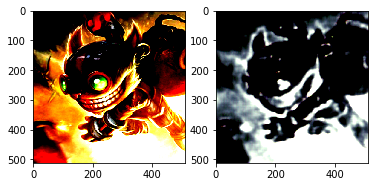

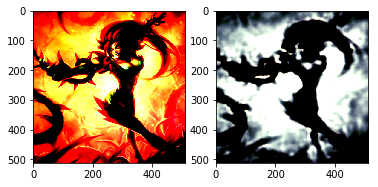

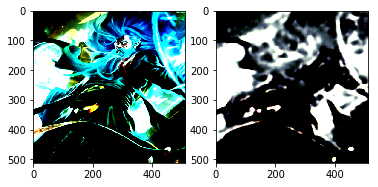

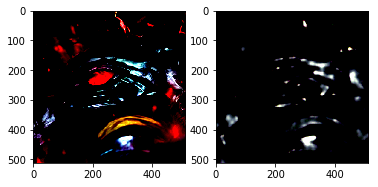

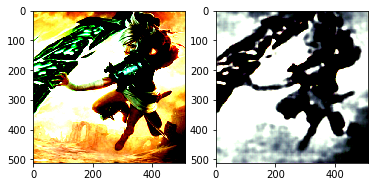

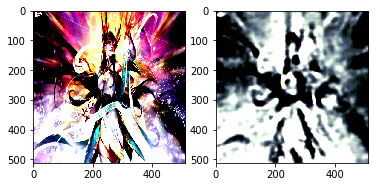

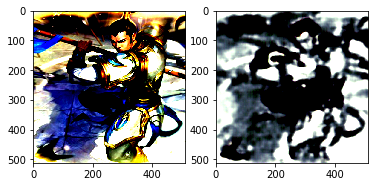

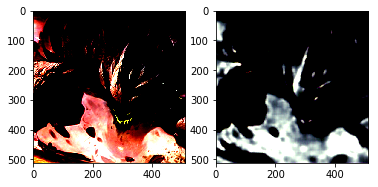

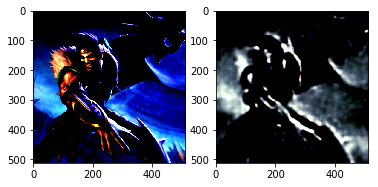

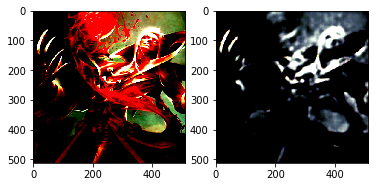

In [15]:
x = next(iter(dataloader)).to(device)

encoded = net.encode(x)
encoded = encoded.view(x.size(0), -1)
mu, logvar = net.fc1(encoded), net.fc2(encoded)
z = net.reparameterize(mu, logvar)
z = z.reshape(x.size(0), net.z_channels, net.z_h, net.z_w)
x_pred = net.decode(z)

for i in range(10):
    fig, axes = plt.subplots(1, 2)
    curr = x[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    axes[0].imshow(curr)

    curr = x_pred[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    axes[1].imshow(curr)
plt.show()

In [23]:
torch.cuda.set_device(3)
device = torch.cuda.current_device()

net = net.to(device).eval()

In [17]:
torch.save(net, "net_march14.pt")

In [24]:
z = torch.randn(args.batch_size, args.z_channels, args.z_h, args.z_w, device=device)
x_sample = net.decode(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


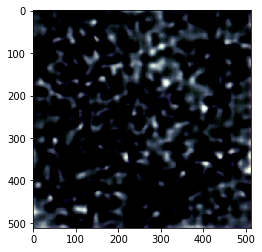

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


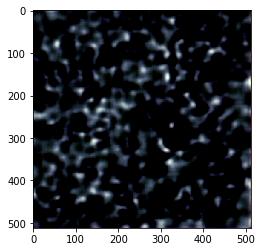

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


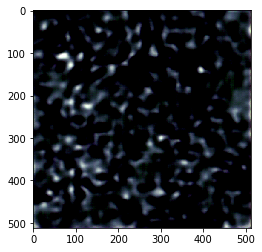

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


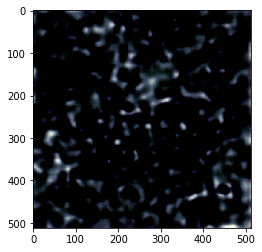

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


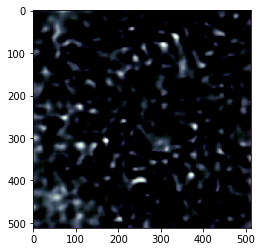

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


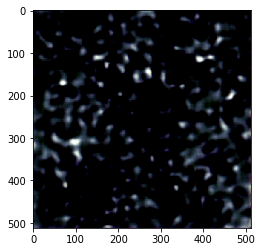

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


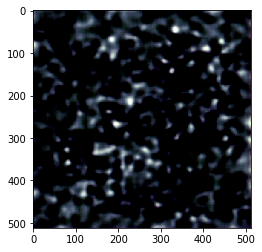

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


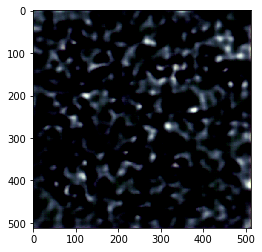

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


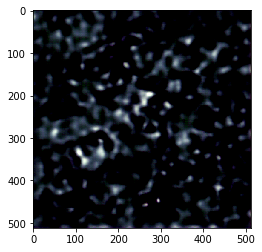

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


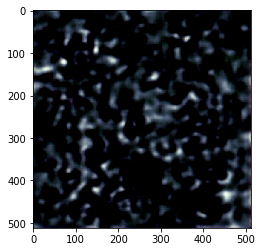

In [25]:
for i in range(10):
    curr = x_sample[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    plt.imshow(curr)
    plt.show()